# 신용카드 고객 이탈 예측 - 베이스라인 모델

이 노트북은 BankChurners.csv 데이터를 활용하여 간단한 이탈 예측(Churn Prediction) 베이스라인 모델을 구축합니다.

## 목차
1. 필요한 라이브러리 임포트
2. 데이터 불러오기 및 확인
3. 데이터 전처리
4. 학습/테스트 데이터 분리
5. 베이스라인 모델 학습
6. 모델 예측 및 평가

In [7]:
# 1. 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [8]:
# 2. 데이터 불러오기 및 확인
df = pd.read_csv('./data/BankChurners.csv')
print('Shape:', df.shape)
df.head()

Shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [9]:
# 3. 데이터 전처리 (간단)
# 타겟 컬럼: 'Attrition_Flag' (이탈: 'Attrited Customer', 유지: 'Existing Customer')
df = df.copy()
df['Attrition_Binary'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)

# 불필요한 컬럼 제거 (고객번호 등)
drop_cols = [col for col in ['CLIENTNUM', 'Attrition_Flag', "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1"] if col in df.columns]
df = df.drop(columns=drop_cols)

# 간단한 결측치 처리 (최빈값/평균 대체)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].mean())

# 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, drop_first=True)

In [10]:
df.shape


(10127, 33)

In [11]:
# 4. 학습/테스트 데이터 분리
X = df.drop('Attrition_Binary', axis=1)
y = df['Attrition_Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (8101, 32) Test shape: (2026, 32)


In [35]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

results = []

models = [
    ('LogReg', LogisticRegression(max_iter=1000)),
    ('DTree', DecisionTreeClassifier(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('LGBM', LGBMClassifier(random_state=42)), 
    # ('SVC', SVC(kernel='linear', probability=True, random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    # ROC-AUC와 PR-AUC는 predict_proba를 지원하는 모델만 계산 가능
    roc_auc = None
    pr_auc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)  # PR-AUC 계산
    
    # 각종 지표 계산
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc if roc_auc is not None else 0.0,
        'pr_auc': pr_auc if pr_auc is not None else 0.0,  # PR-AUC 추가
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)
    }
    results.append(metrics)
    print('-' * 40)
    print(f"Model: {name}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"PR-AUC: {metrics['pr_auc']:.4f}")
    print(f"RECALL: {metrics['recall']:.4f}")
print('-' * 40)

/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------
Model: LogReg
ROC-AUC: 0.8993
PR-AUC: 0.6945
RECALL: 0.4954
----------------------------------------
Model: DTree
ROC-AUC: 0.8707
PR-AUC: 0.6588
RECALL: 0.7785
----------------------------------------
Model: RF
ROC-AUC: 0.9838
PR-AUC: 0.9416
RECALL: 0.7754
----------------------------------------
Model: XGB
ROC-AUC: 0.9920
PR-AUC: 0.9622
RECALL: 0.8585
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start

In [32]:
df_results = pd.DataFrame(results)
print(results)

[{'accuracy': 0.8928923988153998, 'roc_auc': 0.8993406593406594, 'pr_auc': 0.6944689674186361, 'f1': 0.5974025974025974, 'recall': 0.49538461538461537, 'precision': 0.7523364485981309}, {'accuracy': 0.9333662388943732, 'roc_auc': 0.8707122507122508, 'pr_auc': 0.6587999338684734, 'f1': 0.7893915756630265, 'recall': 0.7784615384615384, 'precision': 0.8006329113924051}, {'accuracy': 0.9555774925962488, 'roc_auc': 0.983758874869986, 'pr_auc': 0.9416161772321365, 'f1': 0.8484848484848485, 'recall': 0.7753846153846153, 'precision': 0.9368029739776952}, {'accuracy': 0.9664363277393879, 'roc_auc': 0.992022792022792, 'pr_auc': 0.9622372183175707, 'f1': 0.8913738019169329, 'recall': 0.8584615384615385, 'precision': 0.9269102990033222}, {'accuracy': 0.9713721618953604, 'roc_auc': 0.9924135124135125, 'pr_auc': 0.9667268691664758, 'f1': 0.9076433121019108, 'recall': 0.8769230769230769, 'precision': 0.9405940594059405}]


/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/sit

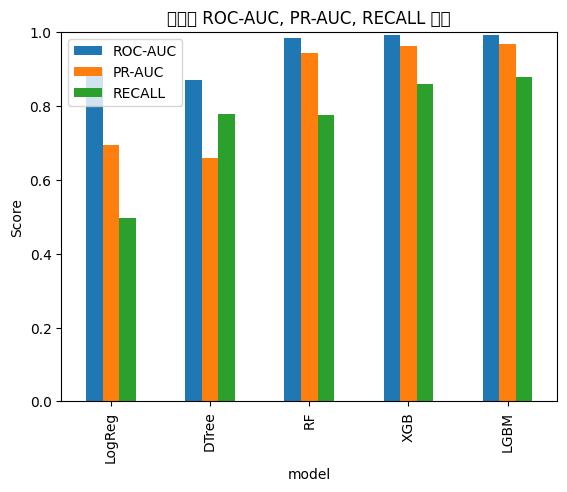

In [37]:
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)  # 'model' 컬럼 포함됨


metrics_to_plot = ['roc_auc', 'pr_auc', 'recall']
df_plot = df_results.set_index('model')[metrics_to_plot]

df_plot.plot(kind='bar')
plt.title('모델별 ROC-AUC, PR-AUC, RECALL 비교')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(['ROC-AUC', 'PR-AUC', 'RECALL'])
plt.show()


/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gimjunseog/projects/skn-2nd-3team/venv/lib/python3.13/sit

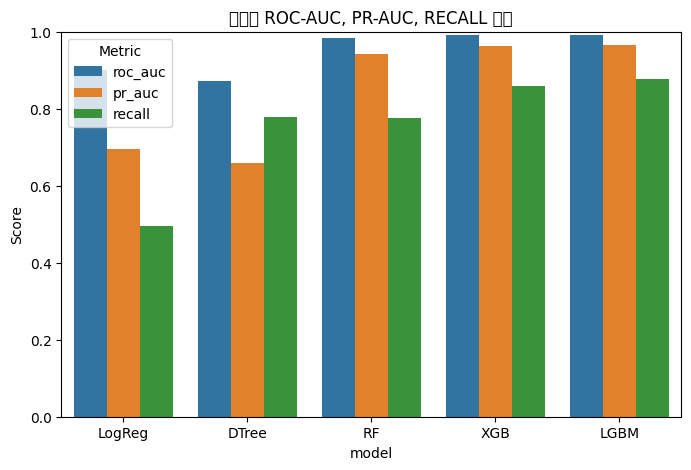

In [38]:
import seaborn as sns

df_melted = df_results.melt(id_vars='model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')
plt.figure(figsize=(8,5))
sns.barplot(data=df_melted, x='model', y='Score', hue='Metric')
plt.title('모델별 ROC-AUC, PR-AUC, RECALL 비교')
plt.ylim(0, 1)
plt.show()